In [1]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt
import jax.numpy as jnp

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import jax
import numpy as np

import jax.random as jrandom

import time
from functools import partial
from pcuq_utils import *

jitter = 1e-12

def build_matrix():
    m = np.zeros((11, 11))
    m[0][0] = -1
    m[0][1] = 1
    m[0][4] = 1
    m[1][0] = -1
    m[1][1] = 1
    m[1][10] = 1
    m[2][0] = 1
    m[2][1] = -1
    m[2][2] = -1
    m[2][3] = 1
    m[3][2] = 1
    m[3][3] = -1
    m[3][4] = -1
    m[4][4] = 1
    m[4][5] = -1
    m[4][6] = 1
    m[5][4] = 1
    m[5][8] = -1
    m[5][9] = 1
    m[6][5] = -1
    m[6][6] = 1
    m[6][7] = 1
    m[7][5] = 1
    m[7][6] = -1
    m[7][7] = -1
    m[8][2] = -1
    m[8][3] = 1
    m[8][7] = 1
    m[9][8] = -1
    m[9][9] = 1
    m[9][10] = 1
    m[10][8] = 1
    m[10][9] = -1
    m[10][10] = -1
    return m

Mat = jnp.array(build_matrix())

def build_fluxes(y, args):
    x1 = args[0] * y[0] * y[1]
    x2 = args[1] * y[2]
    x3 = args[2] * y[2] * y[8]
    x4 = args[3] * y[3]
    x5 = args[4] * y[3]
    x6 = args[5] * y[4] * y[6]
    x7 = args[6] * y[7]
    x8 = args[7] * y[7]
    x9 = args[8] * y[5] * y[9]
    x10 = args[9] * y[10]
    x11 = args[10] * y[10]
    return jnp.array([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11])

def f(t, y, args):
    # cytoplasm = 1
    fxs = build_fluxes(y, args)
    return jnp.dot(Mat, fxs) + jitter


x_init = jnp.array([2, 2.5, 0.0, 0.0, 0.0, 0.0, 2.5, 0.0, 2.5, 3.0, 0.0])
params_vals = jnp.array([0.53, 0.0072, 0.625, 0.00245, 0.0315, 0.8, 0.0075, 0.071, 0.92, 0.00122, 0.87])

In [3]:
from diffrax import diffeqsolve, ODETerm, Tsit5, Dopri8, SaveAt

tmax = 60.0
tobs = 45.0

term = ODETerm(f)
solver = Dopri8()
saveat = SaveAt(dense=True)

solution = diffeqsolve(term, solver, t0=0, t1=tmax, dt0=5e-2, args=params_vals, y0=x_init, saveat=saveat)


def f_misspecified(t, y, args):
    # cytoplasm = 1
    coef = 1 + 0.5 * jnp.sin(t/tobs * 2 * jnp.pi)
    args0 = coef * args
    fxs = build_fluxes(y, args0)
    return jnp.dot(Mat, fxs) + jitter

term = ODETerm(f_misspecified)
solver = Dopri8()
saveat = SaveAt(dense=True)

sol = diffeqsolve(term, solver, t0=0, t1=tmax, dt0=2e-2, args=params_vals, y0=x_init, saveat=saveat)

In [4]:
transform_func = jax.nn.sigmoid
#transform_func = jnp.cos

def build_erk(y0, ts, params):
    def f(t, y, args):
        # cytoplasm = 1
        fxs = build_fluxes(y, args)
        return jnp.dot(Mat, fxs) + jitter
        
    term = ODETerm(f)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)
    args = transform_func(params)
    return diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], dt0=0.02, y0=y0, saveat=saveat, args=args).ys

In [6]:
specified = False
solfunc = solution.evaluate if specified else sol.evaluate

key = jrandom.PRNGKey(124) 
tx = jnp.linspace(0, tobs, 80)[1:]
obs = jax.vmap(solfunc)(tx)

ty = jnp.linspace(0, tmax, 250)
ob1 = jax.vmap(solfunc)(ty)
noise_sig = 0.1 * jnp.std(ob1, 0, keepdims=True)

obs_1 = jax.vmap(solution.evaluate)(tx)
obs_2 = jax.vmap(sol.evaluate)(tx)

rng, key = jrandom.split(key)
obs += noise_sig * jrandom.normal(rng, obs.shape)
noise_sigma = noise_sig.squeeze()

In [34]:
tx[1]-tx[0]

Array(0.56962025, dtype=float32)

In [7]:
inhibitor = 0.01

def build_erk_inhibited(y0, ts, params):
    def f(t, y, args):
        # cytoplasm = 1
        fxs = build_fluxes(y, args)
        return jnp.dot(Mat, fxs) + jitter
        
    term = ODETerm(f)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)
    args = transform_func(params).at[5].multiply(inhibitor)
    #args = jax.nn.sigmoid(params).at[5].multiply(inhibitor)
    return diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], dt0=2e-2, y0=y0, saveat=saveat, args=args).ys

def f_misspecified_inhibited(t, y, args):
    # cytoplasm = 1
    coef = 1 + 0.5*jnp.sin(t/tobs * 2 * jnp.pi)
    #coef = jnp.exp(brownian_motion.evaluate(t / tmax * tc0) * 2.0)
    args0 = coef * args
    args0 = args0.at[5].multiply(inhibitor)
    fxs = build_fluxes(y, args0)
    return jnp.dot(Mat, fxs) + jitter

term = ODETerm(f_misspecified_inhibited)
solver = Dopri8()
saveat = SaveAt(dense=True)

sol_inhibited = diffeqsolve(term, solver, t0=0, t1=tmax, dt0=2e-2, args=params_vals, y0=x_init, saveat=saveat)

In [8]:
#func_dict = build_func_dict(obs, tx, 10 * jnp.square(noise_sigma), x_init, noise_sigma, build_erk, product=False)
func_dict = build_func_dict(obs, tx, jnp.square(noise_sigma), x_init, noise_sigma, build_erk, product=True)

n_iter = 1000
ss = 1e-5

true_params_init = jax.scipy.special.logit(params_vals)
params_mmd = true_params_init

gfunc = jax.value_and_grad(func_dict['mmd-bayes'])

for i in range(n_iter):
    ll, g = gfunc(params_mmd)
    g -= 1e-3 * params_mmd
    params_mmd += ss * g

In [22]:
n_iters = 5000
n_particles = 20

func_dict = build_func_dict(obs, tx, jnp.square(noise_sigma), x_init, noise_sigma, build_erk, product=True)

key = jrandom.PRNGKey(124)
func = func_dict['pcuq']
rng, key = jrandom.split(key)

params_init = jnp.stack([params_mmd] * n_particles, 0)
params_init += 1e-4 * jrandom.normal(rng, params_init.shape)

rng, key = jrandom.split(key)
tr_pcuq = langevin(func, n_iters, 0.01, params_init, 1e-3, rng)

1000: 0.08925621956586838
2000: 0.12141159176826477
3000: 0.10178478807210922
4000: 0.1271844208240509
5000: 0.13890334963798523


In [23]:
func = func_dict['bayes']
rng, key = jrandom.split(key)

params_init = jnp.stack([params_mmd] * n_particles, 0)
params_init += 1e-6 * jrandom.normal(rng, params_init.shape)

rng, key = jrandom.split(key)
tr_bayes = langevin(func, n_iters, 1e-6, params_init, 1.0, rng, multi=True)

1000: [-9741.932 -9663.892 -9701.367 -9703.546 -9738.73  -9718.125 -9729.489
 -9698.889 -9724.153 -9712.192 -9715.749 -9736.126 -9735.983 -9669.481
 -9681.701 -9718.866 -9717.73  -9717.285 -9720.732 -9773.731]
2000: [-9418.777 -9322.593 -9393.105 -9427.664 -9397.481 -9406.335 -9366.806
 -9430.703 -9422.073 -9394.512 -9441.221 -9414.115 -9409.862 -9358.71
 -9390.217 -9437.233 -9359.912 -9390.579 -9414.928 -9451.259]
3000: [-9173.658  -9137.492  -9192.588  -9226.345  -9160.03   -9184.64
 -9145.553  -9159.594  -9136.071  -9154.352  -9210.2295 -9162.06
 -9136.1045 -9134.483  -9153.689  -9211.383  -9142.44   -9167.654
 -9223.198  -9174.793 ]
4000: [-8979.484 -8971.029 -8990.549 -9032.84  -8965.664 -9007.84  -8987.248
 -9000.825 -8942.608 -8979.389 -9010.591 -8991.569 -8952.856 -8966.993
 -8955.857 -9006.4   -8955.916 -8957.514 -9013.215 -8975.27 ]
5000: [-8874.139 -8839.341 -8871.97  -8863.353 -8849.719 -8892.376 -8861.884
 -8865.199 -8825.542 -8833.403 -8889.56  -8880.365 -8855.356 -8845.2

### Make subfigures

In [38]:
def plot_main(params, axes, func, sol_func, ids, title=False, scatter=False):
    ts = jnp.linspace(0.0, tmax, 1000)
    traj = jax.vmap(sol_func)(ts)
    trajs = jax.vmap(func, (None, None, 0))(x_init, ts, params)
    
    keys = ['Raf1', 'RKIP', 'Raf1_RKIP', 'Raf1_RKIP_ERKPP', 'ERK', 'RKIPP', 'MEKPP', 'MEKPP_ERK', 'ERKPP', 'RP', 'RKIPP_RP']
    
    t1 = jnp.sort(trajs, 0)
        
    #smin = t1[5, :, :]
    #smax = t1[-6, :, :]
    #ms = jnp.mean(t1[5:-5, :, :], 0)
    ms = jnp.mean(t1, 0)
    stds = jnp.std(t1, 0)# + noise_sigma[None, :]
    quart = -0.67448
    
    for i, idx in enumerate(ids):
        axes[i].plot(ts, traj[:, idx], c='k')
        if scatter:
            axes[i].scatter(tx, obs[:, idx], marker='x', s=10)
        axes[i].plot(ts, ms[:, idx], c='r', linewidth=0.5)
        axes[i].fill_between(ts, ms[:, idx] - quart * stds[:, idx], ms[:, idx] + quart * stds[:, idx], color='gray', alpha=.5)
        if title:
            tl = keys[idx]
            if scatter is False:
                tl += '+MEKi'
            axes[i].set_title(tl)
    return axes

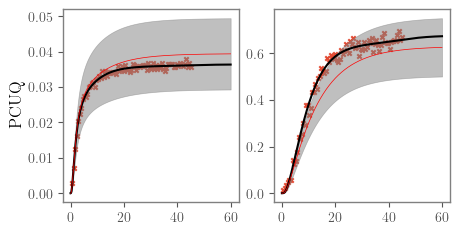

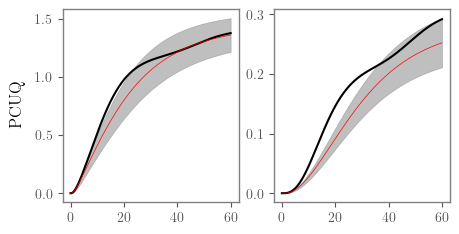

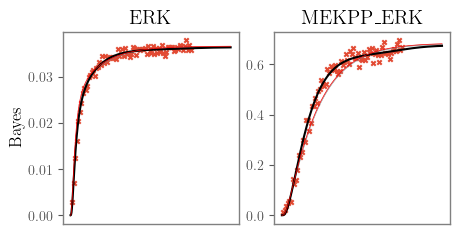

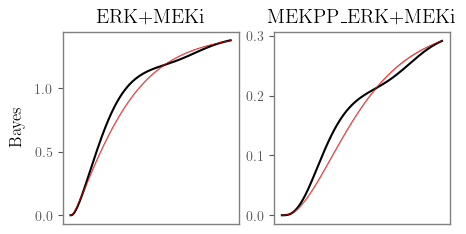

In [41]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'sans-serif'
})
from matplotlib import rc
rc('font',**{'family':'serif'})

ids = [4, 7]

def plot_cis(tr, title, show_title=True, xticks=True):
    fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))
    ax0 = plot_main(tr[-1], axs, build_erk, solfunc, ids, show_title, True)
    fig.supylabel(title)
    
    for ax in ax0:
        ax.grid(False)
        ax.set_facecolor('w')
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color('0.5')
        ax.spines['right'].set_color('0.5')
        ax.spines['left'].set_color('0.5')
        if xticks is False:
            ax.set_xticks([])
    plt.savefig(title + '.pdf', bbox_inches='tight')
    
    fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))
    ax0 = plot_main(tr[-1], axs, build_erk_inhibited, sol_inhibited.evaluate, ids, show_title, False)
    fig.supylabel(title)
    #ax0[0].set_xticks([])
    #ax0[1].set_xticks([])
    
    for ax in ax0:
        ax.grid(False)
        ax.set_facecolor('w')
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color('0.5')
        ax.spines['right'].set_color('0.5')
        ax.spines['left'].set_color('0.5')
        if xticks is False:
            ax.set_xticks([])
            
    plt.savefig(title + '_inhibited.pdf', bbox_inches='tight')

plot_cis(tr_pcuq, 'PCUQ', False, True)
plot_cis(tr_bayes, 'Bayes', True, False)

### Plot all covariates

In [29]:
def plot(params, axes, func, sol_func, scatter=False, title=False):
    ts = jnp.linspace(0.0, tmax, 1000)
    traj = jax.vmap(sol_func)(ts)
    trajs = jax.vmap(func, (None, None, 0))(x_init, ts, params)
    
    keys = ['Raf1', 'RKIP', 'Raf1_RKIP', 'Raf1_RKIP_ERKPP', 'ERK', 'RKIPP', 'MEKPP', 'MEKPP_ERK', 'ERKPP', 'RP', 'RKIPP_RP']
    
    t1 = jnp.sort(trajs, 0)
        
    ms = jnp.mean(t1, 0)
    stds = jnp.std(t1, 0)# + noise_sigma[None, :]
    quart = 0.67448
    handles = []
    for i in range(11):
        line1, = axes[i].plot(ts, traj[:, i], c='k', label='ground truth')
        handles.append(line1)
        if scatter:
            points1 = axes[i].scatter(tx, obs[:, i], marker='x', label='observation')
            handles.append(points1)
            
        line2, = axes[i].plot(ts, ms[:, i], c='r', linewidth=0.5, linestyle='dashed', label='predictive mean')
        handles.append(line2)
        axes[i].fill_between(ts, ms[:, i] - quart * stds[:, i], ms[:, i] + quart * stds[:, i], color='gray', alpha=.5)
        if title:
            axes[i].set_title(keys[i])
    return axes, handles

In [32]:
from matplotlib.gridspec import GridSpec

def plot_covariates(tr, title):
    fig = plt.figure(figsize=(25, 4), facecolor='w')
    
    gs = GridSpec(4, 12, figure=fig, hspace=0.5, wspace=0.4, height_ratios=[1, 1, 1, 1])
    
    ax1 = [gs[0:2, i] for i in range(11)]
    ax1 = [fig.add_subplot(g) for g in ax1]
    
    ax2 = [gs[2:4, i] for i in range(11)]
    ax2 = [fig.add_subplot(g) for g in ax2]
    
    
    ax1, handles = plot(tr[-1], ax1, build_erk, solfunc, True, True)
    ax2, _ = plot(tr[-1], ax2, build_erk_inhibited, sol_inhibited.evaluate)
    
    def process(ax):
        ax.grid(False)
        ax.set_facecolor('w')
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color('0.5')
        ax.spines['right'].set_color('0.5')
        ax.spines['left'].set_color('0.5')
    
    for j in range(11):
        process(ax1[j])
        process(ax2[j])
        ax1[j].set_xticks([])
    
    leg = fig.add_subplot(gs[1:3, 11])
    lg = leg.legend(handles=[handles[0], handles[1], handles[2]], loc='center')
    leg.set_xticks([])
    leg.set_yticks([])
    leg.set_facecolor('w')
    frame = lg.get_frame()
    frame.set_facecolor('w')
    frame.set_edgecolor('0.5')
    fig.supylabel(title, x=0.105, y=0.5)
    
    plt.savefig(title+"_erk.pdf", bbox_inches='tight')

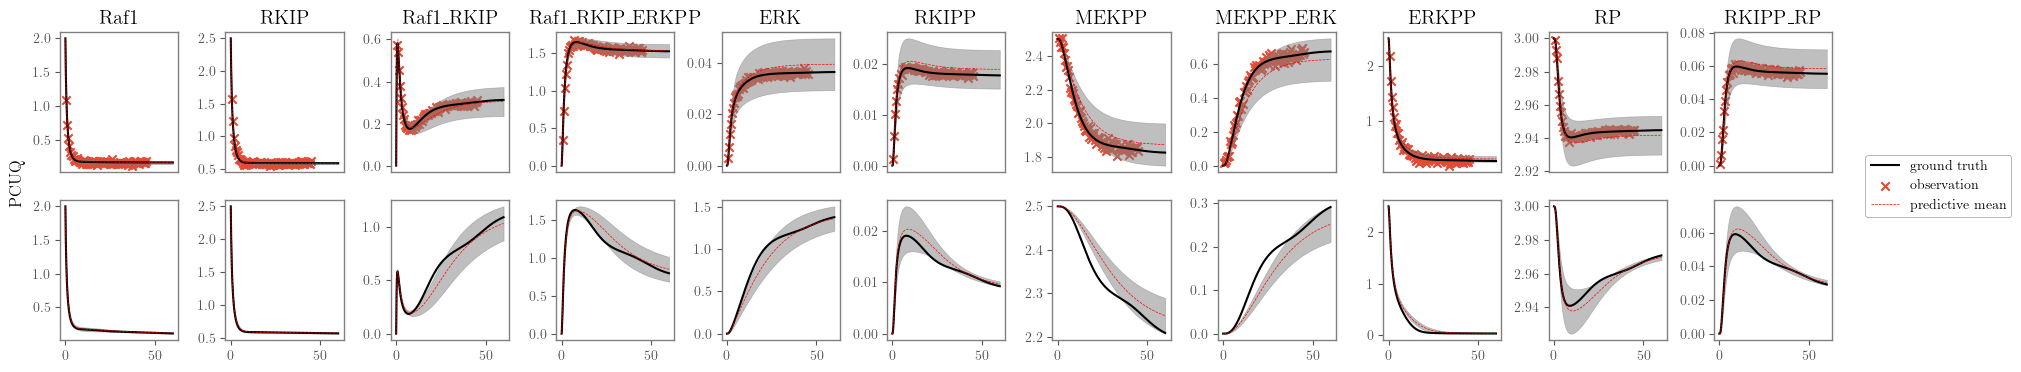

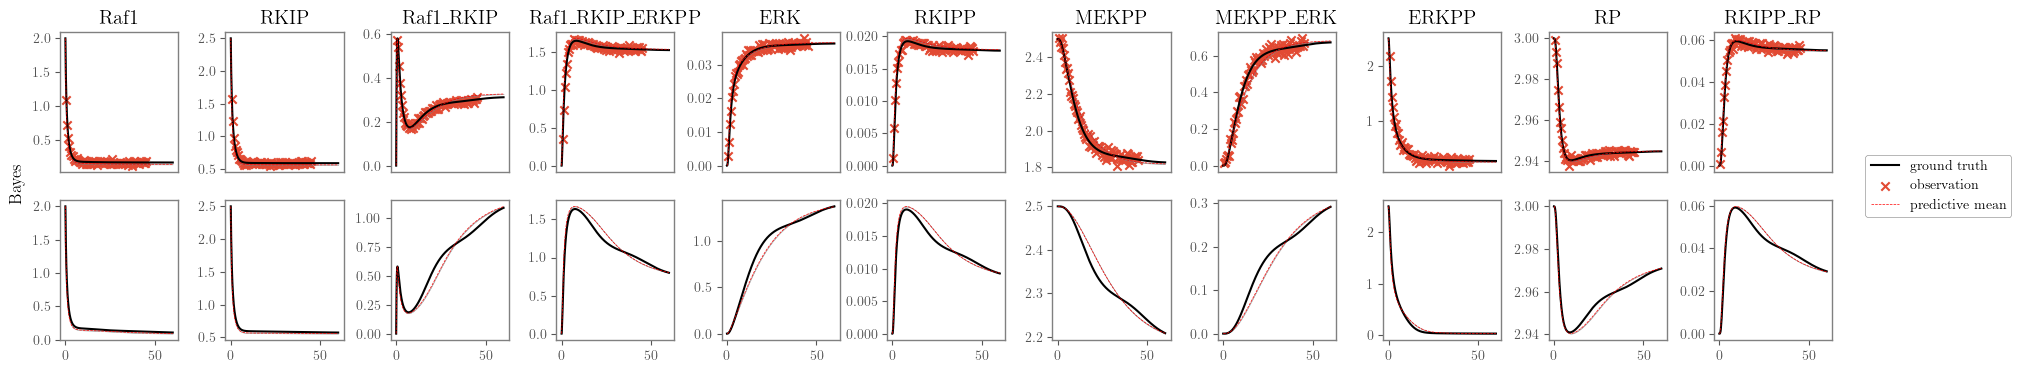

In [33]:
plot_covariates(tr_pcuq, 'PCUQ')
plot_covariates(tr_bayes, 'Bayes')